# Planet: Understanding the Amazon from Space

---

Use satellite data to track the human footprint in the Amazon rainforest

After data modeling 

### 5. Model Evaluation Measure

Definitions: <br>
Precision describes how good a model is at predicting the positive class. <br>
Recall describes how good the model is at predicting the positive class when the actual outcome is positive.<br>
F1 is the mean of these two scores, specifically the harmonic mean instead of the arithmetic mean because the values are proportions.<br>
F-beta metric is a generalization of F1 that allows a term called beta to be introduced that weights how important recall is compared to precision when calculating the mean <br>
F2 score is when recall is valued twice as highly as precision

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

In [2]:
import tensorflow as tf
from keras import backend

Using TensorFlow backend.


In [3]:
def load_dataset():
    data = np.load('planet_data.npz')
    X, y = data['arr_0'], data['arr_1']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return X_train, y_train, X_test, y_test

In [4]:
trainX, trainY, testX, testY = load_dataset()

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


28,000 examples in the training dataset and a little more than 12,000 examples in the test set.

In [5]:
# make all one predictions
train_yhat = np.asarray([np.ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = np.asarray([np.ones(testY.shape[1]) for _ in range(testY.shape[0])])
# evaluate predictions
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

C:\Users\Nrepesh Joshi\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


All Ones: train=0.484, test=0.484


We will require a version of the F-beta score calculation in Keras to use as a metric.

In [6]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

In [7]:
# evaluate predictions with keras
#train_score = fbeta(backend.variable(trainY), backend.variable(train_yhat))
#test_score = fbeta(backend.variable(testY), backend.variable(test_yhat))
#print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))

All Ones (keras): train=0.484, test=0.484


We can use the score of 0.483 on the test set as a <B>naive forecast</B> to which all models in the subsequent sections can be compared to determine if they are skillful or not.

### 6. Baseline Model

VGG-type structure: That is blocks of convolutional layers with small 3×3 filters followed by a max pooling layer, with this pattern repeating with a doubling in the number of filters with each block added.

Each block will have two convolutional layers with 3×3 filters, ReLU activation and He weight initialization with same padding, ensuring the output feature maps have the same width and height. These will be followed by a max pooling layer with a 3×3 kernel. Three of these blocks will be used with 32, 64 and 128 filters respectively.

In [8]:
import sys 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

In [9]:
def define_model(in_shape = (128, 128, 3), out_shape = 17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In this case, we will use the sigmoid activation function in the output layer and optimize the binary cross entropy loss function.

The model will be optimized with mini-batch stochastic gradient descent with a conservative learning rate of 0.01 and a momentum of 0.9, and the model will keep track of the “fbeta” metric during training.

In [10]:
# plot diagnostic curves
def summarize_diagnostics(history):
    #plot loss 
    plt.subplots(211)
    plt.title('Cross Entrophy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color ='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Fbeta')
    pyplot.plot(history.history['fbeta'], color='blue', label='train')
    pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.close()

The summarize_diagnostics() function will create a figure from this recorded history data with one plot showing loss and another the F-beta scores for the model at the end of each training epoch on the train dataset (blue lines) and test dataset (orange lines).

The fit_generator() function called to fit the model returns a dictionary containing the loss and F-beta scores recorded each epoch on the train and test dataset. We can create a plot of these traces that can provide insight into the learning dynamics of the model.

In [2]:
def run_test_harness():
    trainX,trainY,testX,testY = load_dataset()
    # data generator to rescale and normalize
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    #The data generator itself is in fact an iterator, returning batches of image samples when requested. We can configure the batch size and prepare the data generator and get batches of images by calling the flow() function.
    train_it = datagen.flow(trainX, trainY, batch_size = 128)
    test_it = datagen.flow(testX, testY, batch_size = 128)
    
    model = define_model()
    #fit model 
    history = model.fit_generator(train_it, steps_per_epoch = len(train_it), 
                                 validation_data = test_it, validation_steps = len(test_it), epochs = 50, verbose = 0)
    # evaluate model 
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose = 0)
    print('> loss = %.3f, fbeta=%.3f' % (loss, fbeta))
    summarize_diagnostics(history)
   
#Initial run 
run_test_harness()    

The input and output elements of each of the train and test datasets is printed, confirming that the same data split was performed as before. 

In this case, the baseline model achieved an F-beta score of about 0.831, which is quite a bit better than the naive score of 0.483 reported in the previous section. This suggests that the baseline model is skillful.




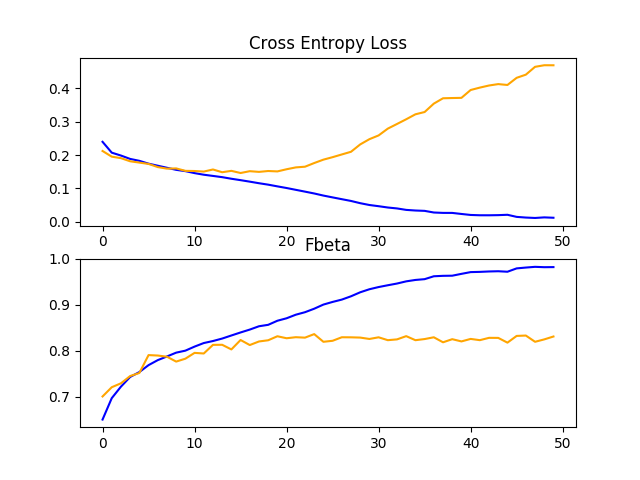

In this case, the plot of the loss learning curves suggests that the model has overfit the training dataset, perhaps around epoch 20 out of 50, although the overfitting has not seemingly negatively impacted the performance of the model on the test dataset with regard to the F-beta score.